In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Fei Tian Middletown /Fall 2022/ML & AI/Final Project/src

/content/drive/MyDrive/Fei Tian Middletown /Fall 2022/ML & AI/Final Project/src


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


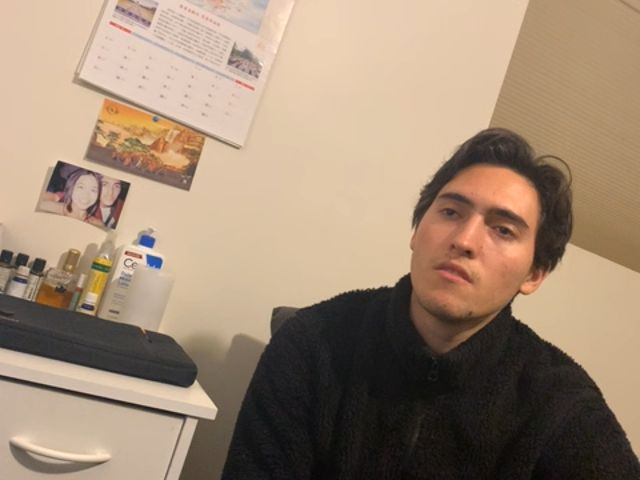

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

  

# Imports

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from general import GeneralUtil as util

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train Image Classifier CNN

## 1. Load Data

In [5]:
TRAINING_PATH = '../images/training'
TESTING_PATH = '../images/testing'

In [189]:
# Set the batch size
batch_size = 5
# Set the classes
classes = ('A', 'B', 'C', 'D', 'E')

# --------------------------------------------------------------------------------------------------
# Set up transformer to normalize and transform the data
# --------------------------------------------------------------------------------------------------
train_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        # https://pytorch.org/vision/main/auto_examples/plot_transforms.html#randomresizedcrop
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), 
                ratio=(0.9, 1.1)),
        # https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# --------------------------------------------------------------------------------------------------
# Create the training and test datasets as well as the data loaders
# --------------------------------------------------------------------------------------------------
# Data Sets
train_dataset = datasets.ImageFolder(TRAINING_PATH, transform=train_transform)
test_dataset = datasets.ImageFolder(TESTING_PATH, transform=test_transform)
val_dataset = datasets.ImageFolder(TRAINING_PATH, transform=train_transform)

torch.manual_seed(42) 
train_set, _ = torch.utils.data.random_split(train_dataset, [310, 50])
torch.manual_seed(42) # Think why do we do this?
_, val_set = torch.utils.data.random_split(val_dataset, [310, 50])

# Data Loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                          drop_last=True, pin_memory=True,
                                          shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                          shuffle=False, drop_last=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, drop_last=False, num_workers=2)
util.print(f"Successfully loaded images\nBatch size: {batch_size}", color='green')

Successfully loaded images
Batch size: 5


Let's visualize some of the images in the dataset.

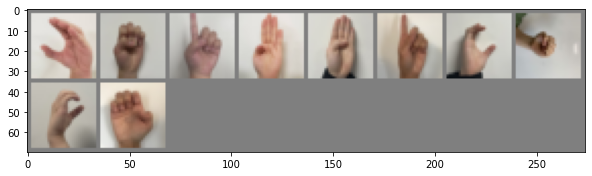

         C          E          D          B          B          D          C          E          C          E


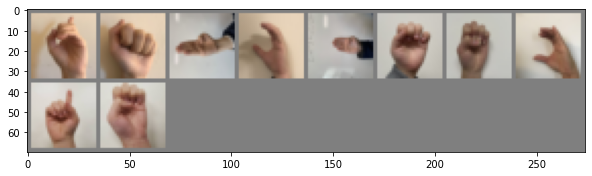

         D          A          B          C          B          E          E          C          D          E


In [171]:
def display_sample_image(imageloader, n=1):
  plt.rcParams["figure.figsize"] = (10, 10)
  def _imshow(img):
      img = img / 2 + 0.5     # unnormalize
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()

  for _ in range(n):
    # get some random images
    dataiter = iter(imageloader)
    images, labels = next(dataiter)

    # show images
    _imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%10s' % classes[labels[j]] for j in range(batch_size)))

display_sample_image(train_loader, n=2)


## 2. Build CNN Architecture

In [191]:
class ASL_CNN(nn.Module):
    def __init__(self, num_classes: int = 5, 
                 dropout: float = 0.5) -> None:
        super().__init__()
        
        self.features = nn.Sequential(
            # Conv1 https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Conv2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), #  15x15

            # Conv3
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), #  7x7

            # # Conv4
            # nn.Conv2d(384, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256),
            # nn.ReLU(inplace=True),

            # # Conv5
            # nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256),
            # nn.ReLU(inplace=True),
            # #nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3)) 
        # average pooling, just specify output size
        # https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html


        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), # p = dropout probability
            nn.Linear(256 * 3 * 3, 520),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=dropout),
            nn.Linear(520, 520),
            nn.ReLU(inplace=True),
            nn.Linear(520, num_classes), 
        )

        # initialize the weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Based on our previous discussion, we should initialize the convolutions according to the activation function
                # Fan-out focuses on the gradient distribution, 
                # and is commonly used
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

### 2.1 Architecture Consistency Check

In [192]:
# Architechture consistency check
net = ASL_CNN(num_classes=5, dropout=0.3)
img = torch.randn(4,3,32,32, dtype=torch.float)
x1 = net.features(img)
x2 = net(img)
print(x1.shape, x2.shape)
net


torch.Size([4, 256, 7, 7]) torch.Size([4, 5])


ASL_CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(3, 3))
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=2304, out_features=520, bias=True)
    (2): ReLU(inplace=True)
   

## 3. Define Loss Function and Optimizer

In [180]:
torch.cuda.empty_cache()

Let's use cross entropy loss and Adam optimizer.

In [193]:
net = ASL_CNN(num_classes=5, dropout=0.5)
net.to(device)

ASL_CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(3, 3))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=520, bias=True)
    (2): ReLU(inplace=True)
   

In [194]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=6.14E-02, momentum=0.9)

## 4. Train the CNN

In [200]:
import tqdm
def train(device=torch.device("cpu"), scheduler=None):
    net.train()
    progress_bar = tqdm.notebook.tqdm(train_loader, leave=False)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, data in progress_bar:
      # inputs, labels = inputs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs.to(device))
      loss = criterion(outputs, labels.to(device))
      loss.backward()
      optimizer.step()

      progress_bar.set_description(f'Loss: {loss.item():.3f}')

      if scheduler:
          scheduler.step()

      # Calcualte accuracy
      _, predicted = torch.max(outputs.data.detach().cpu(), 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # print statistics
      running_loss += loss.item()

      # if i % 20 == 19:    # print every 30 mini-batches
      #     print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
      #     running_loss = 0.0

    training_loss.append(loss.item())
    training_acc.append(100.*correct/total)

    return running_loss

def validation(testdata_loader, device=torch.device("cpu"), verbose=False):
  correct = 0
  total = 0
  running_loss = 0.0
  net.eval()

  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testdata_loader:
          images, labels = data
          # calculate outputs by running images through the network 
          outputs = net(images.to(device))

          loss = criterion(outputs, labels.to(device))
          running_loss += loss.item()

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data.detach().cpu(), 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predicted):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  if verbose:
    print("=="*30)
    print(f'Accuracy of the network on the test images: {100 * correct / total}%')
    print("=="*30)
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                  accuracy))
  if not verbose:        
    val_acc.append(100. * correct / total)
    val_loss.append(loss.item())

  return running_loss/len(testdata_loader)

#### Train

In [ ]:
training_loss = []
training_acc = []
val_acc = []
val_loss = []
EPOCHS = 50

util.print('Training...', header=True, color='cyan')
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    # training_loss.append(train(device=device))
    train(device=device)
    validation(test_loader, device=device)
    mess = f"Epoch #{epoch+1}\tTrain Loss: {training_loss[-1]:.3f}\tValidation Loss: {val_loss[-1]:.3f}"
    tqdm.tqdm.write(mess)
util.print('Finished Training', color='green')

Training...


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch #1	Train Loss: 1.612	Validation Loss: 1.611


  0%|          | 0/62 [00:00<?, ?it/s]

In [198]:
validation(val_loader, device=device, verbose=True)

Accuracy of the network on the test images: 22.0%
Accuracy for class A     is: 100.0 %
Accuracy for class B     is: 0.0 %
Accuracy for class C     is: 0.0 %
Accuracy for class D     is: 0.0 %
Accuracy for class E     is: 0.0 %


1.6092325091361999

In [166]:
val_acc = val_acc[:-2]
val_loss = val_loss[:-2]

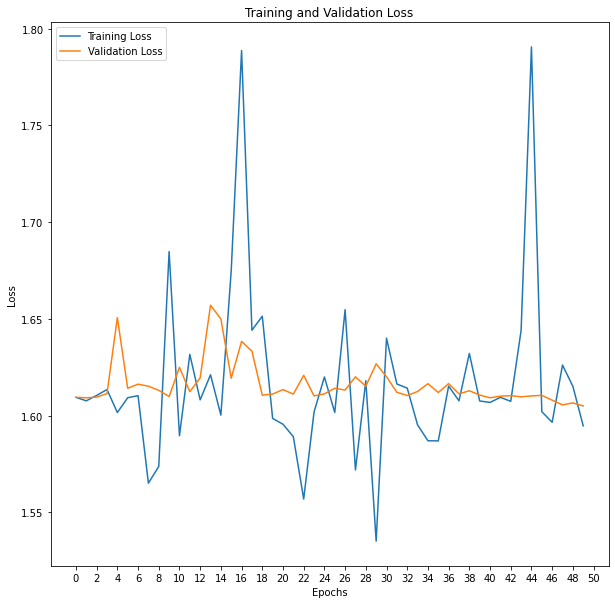

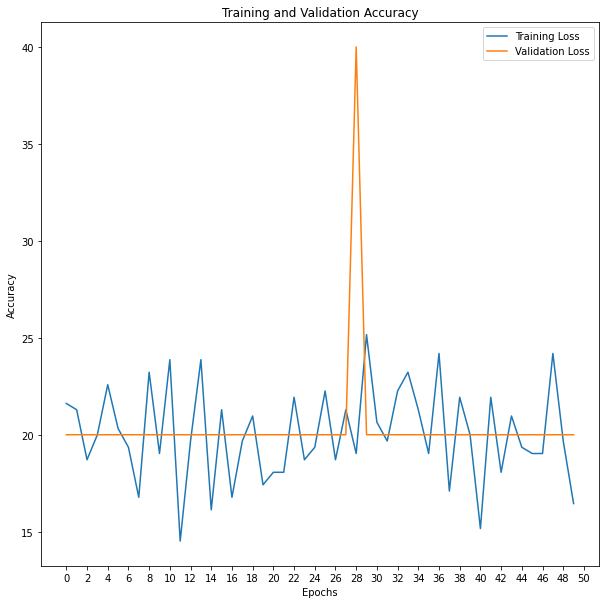

In [169]:
from numpy import arange

def plot_loss(train, test):
  # Generate a sequence of integers to represent the epoch numbers
  epochs = range(EPOCHS)
  
  # Plot and label the training and validation loss values
  plt.plot(epochs, train, label='Training Loss')
  plt.plot(epochs, test, label='Validation Loss')
  
  # Add in a title and axes labels
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  
  # Set the tick locations
  plt.xticks(arange(0, EPOCHS+1, 2))
  
  # Display the plot
  plt.legend(loc='best')
  plt.show()

def plot_accuracy(train, test):
  # Generate a sequence of integers to represent the epoch numbers
  epochs = range(EPOCHS)
  
  # Plot and label the training and validation loss values
  plt.plot(epochs, train, label='Training Loss')
  plt.plot(epochs, test, label='Validation Loss')
  
  # Add in a title and axes labels
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  
  # Set the tick locations
  plt.xticks(arange(0, EPOCHS+1, 2))
  
  # Display the plot
  plt.legend(loc='best')
  plt.show()

plot_loss(training_loss, val_loss)
plot_accuracy(training_acc, val_acc)

## Hyperparameter Tuning

### Optimal learning rate

In [142]:
%%capture
!pip install -q torch-lr-finder

In [144]:
from torch_lr_finder import LRFinder

net = ASL_CNN(num_classes=5, dropout=0.5)
net.to(device)
data_loader = test_loader

optimizer = optim.SGD(net.parameters(), lr=1E-5, momentum=0.9)
lr_finder = LRFinder(net, optimizer, criterion, device=device)
lr_finder.range_test(data_loader, end_lr=1, num_iter=100, step_mode="exp")

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 6.14E-02


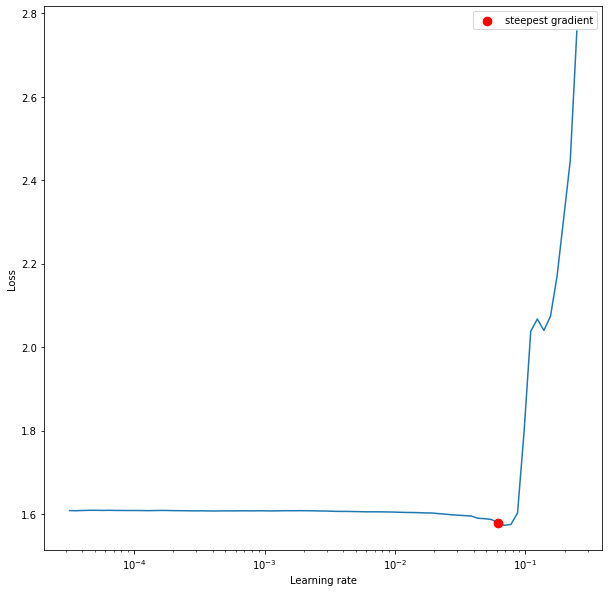

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe21dfd7310>,
 0.06135907273413173)

In [145]:
lr_finder.plot()

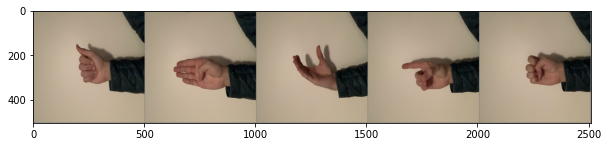

IndexError: ignored

In [63]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

def _imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images
_imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \n', ' '.join( (("\n"*(j % 8== 0))+ '%5s') % classes[labels[j]] 
        for j in range(batch_size)))

### 4.2 Save the Trained Model

In [ ]:
PATH = '../models/asl_cnn.pth'
torch.save(net.state_dict(), PATH)